# Detecting outliers using the rolling mean and median

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import STL
sns.set_context("talk")

In [2]:
### There is a paper called Outliers inside the papers folder


Text(0.5, 0, 'Time')

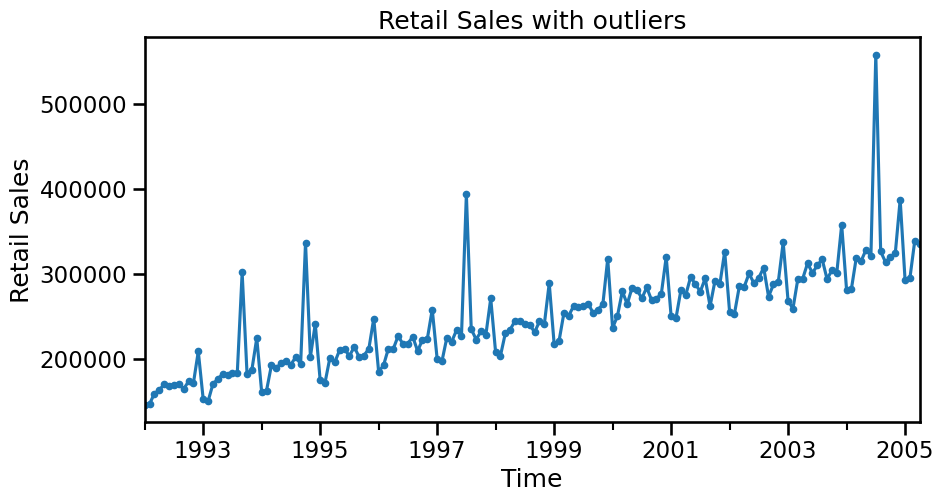

In [3]:
# Load retail sales dataset with the artificially added outliers
df = pd.read_csv(
    "../Datasets/example_retail_sales_with_outliers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

fig, ax = plt.subplots(figsize=[10, 5])
df.plot(y="y", marker=".", figsize=[10, 5], legend=None, ax=ax)
ax.set_title("Retail Sales with outliers")
ax.set_ylabel("Retail Sales")
ax.set_xlabel("Time")

Text(0.5, 0, 'Time')

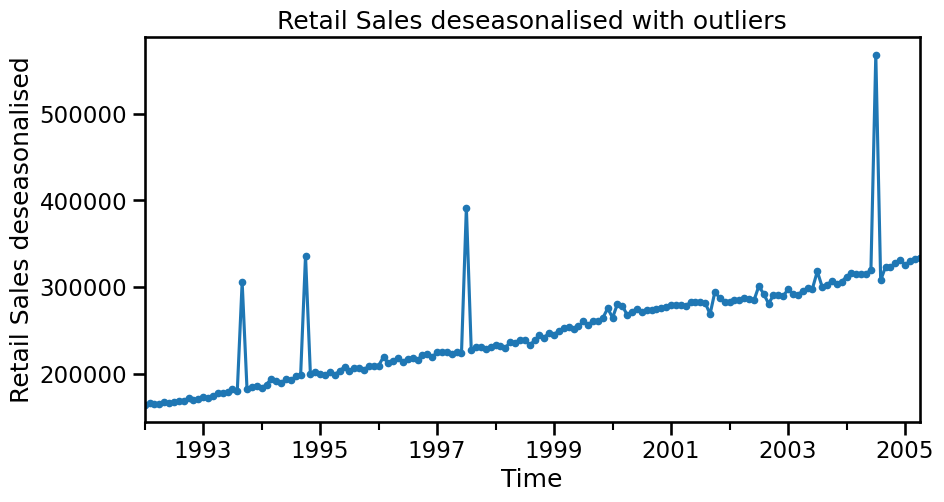

In [4]:
#########  De-seasonalise the data
# A large value for the seasonal parameter is chosen for the STL decomposition, this is based on an assumption that the seasonality is not changing very much. In addition we set the robust parameter to True which implements an outlier robust version of STL decomposition.

# Apply STL decomposition
res = STL(df["y"], robust=True).fit()
seasonal_component = res.seasonal
seasonal_component.head()

df_deseasoned = (df["y"] - seasonal_component).to_frame("y")

df_deseasoned.head()


fig, ax = plt.subplots(figsize=[10, 5])

df_deseasoned.plot(y="y", marker=".", figsize=[10, 5], legend=None, ax=ax)
ax.set_title("Retail Sales deseasonalised with outliers")
ax.set_ylabel("Retail Sales deseasonalised")
ax.set_xlabel("Time")

<img src='../images/Screenshot 2024-05-12 022355.jpg'>

In [ ]:
df_ = df_deseasoned.copy()

# Compute yhat using a rolling mean and the rolling standard deviation which will be used as
# part of the threshold
df_rolling_stats = (
    df_["y"]
    .rolling(
        window=13,  # A window of 13 is chosen to average over yearly seasonality
        center=True,  # Use a centered window for the mean
        min_periods=1,
    )  # Min periods set to 1 so that edge cases also have estimates
    .agg({"rolling_mean": "mean", "rolling_std": "std"})
)


df_[["rolling_mean", "rolling_std"]] = df_rolling_stats

# Apply the threshold criteria to identify an outlier
factor = 3
df_["is_outlier"] = np.abs(df_["y"] - df_["rolling_mean"]) > factor * df_["rolling_std"]

df_.head()

In [ ]:
# Compute the upper and lower boundary of the threshold for plotting
df_["upper"] = df_["rolling_mean"] + factor * df_["rolling_std"]
df_["lower"] = df_["rolling_mean"] - factor * df_["rolling_std"]

# Plot
fig, ax = plt.subplots(figsize=[10, 5])
df_.plot(y=["y", "rolling_mean"], marker=".", ax=ax)
df_.plot(
    y=["upper", "lower"], figsize=[10, 5], ax=ax, color="k", alpha=0.2, legend=None
)

# If any data points are identified as outlier, plot them
if df_["is_outlier"].any():
    df_["y"].loc[df_["is_outlier"]].plot(
        marker="o", color="r", ax=ax, legend=None, linestyle=""
    )
    
ax.set_title("Retail Sales deseasonalised with outliers")
ax.set_ylabel("Retail Sales deseasonalised")
ax.set_xlabel("Time")

<img src='../images/Screenshot 2024-05-12 022502.jpg'>

<img src='../images/Screenshot 2024-05-12 022557.jpg' >  


In [5]:
median_absolute_deviation = lambda y: np.median(np.abs(y - np.median(y)))

In [6]:
df_ = df_deseasoned.copy()

df_rolling_stats = (
    df_["y"]
    .rolling(
        window=13,  # A window of 13 is chosen to average over yearly seasonality
        center=True,  # Use a centered window for the mean
        min_periods=1,
    )  # Min periods set to 1 so that edge cases also have estimates
    .agg({"rolling_median": "median", "rolling_MAD": median_absolute_deviation})
)

df_[["rolling_median", "rolling_MAD"]] = df_rolling_stats

# Apply the threshold criteria to identify an outlier
factor = 3.5
df_["is_outlier"] = (
    np.abs(df_["y"] - df_["rolling_median"]) > factor * df_["rolling_MAD"]
)

df_.head()

,y,rolling_median,rolling_MAD,is_outlier
ds,,,,
1992-01-01,164493.495889,166194.124261,1302.937367,False
1992-02-01,166194.124261,166336.241297,1344.178495,False
1992-03-01,164808.704639,166478.358333,1669.653694,False
1992-04-01,164603.499381,166817.744926,1967.736600,False
1992-05-01,167157.131519,167157.131519,1702.872104,False


Text(0.5, 0, 'Time')

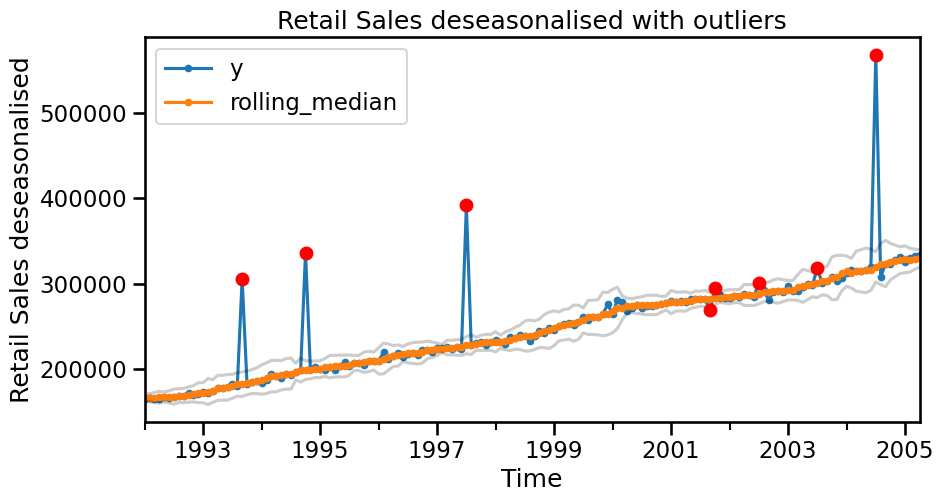

In [7]:
# Compute the upper and lower boundary of the threshold for plotting
df_["upper"] = df_["rolling_median"] + factor * df_["rolling_MAD"]
df_["lower"] = df_["rolling_median"] - factor * df_["rolling_MAD"]

# Plot
fig, ax = plt.subplots(figsize=[10, 5])
df_.plot(y=["y", "rolling_median"], marker=".", ax=ax)
df_.plot(
    y=["upper", "lower"], figsize=[10, 5], ax=ax, color="k", alpha=0.2, legend=None
)

# If any data points are identified as outliers, plot them
if df_["is_outlier"].any():
    df_["y"].loc[df_["is_outlier"]].plot(
        marker="o", color="r", ax=ax, legend=None, linestyle=""
    )
    
ax.set_title("Retail Sales deseasonalised with outliers")
ax.set_ylabel("Retail Sales deseasonalised")
ax.set_xlabel("Time")

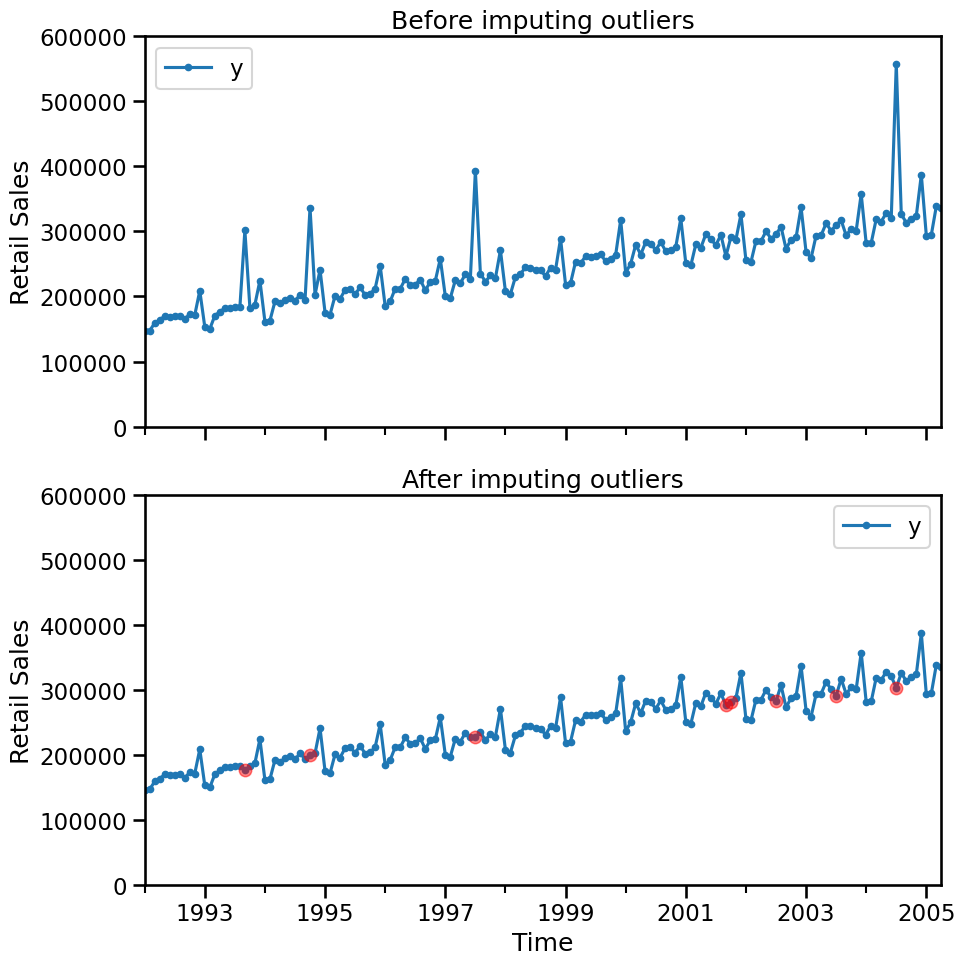

In [8]:
##################   Removing Outliers #############
# Set outliers to NaN
df_.loc[df_["is_outlier"], "y"] = np.NaN

# Apply linear interpolation
df_.interpolate(method="linear", inplace=True)

# Add the seasonality extracted from STL back to deseaoned data
df_["y"] = df_["y"] + res.seasonal

# Plot the data and location of the identified outliers from the rolling median method
fig, ax = plt.subplots(nrows=2, figsize=[10, 10], sharex=True)
df.plot(y="y", marker=".", title="Before imputing outliers", ax=ax[0])
df_.plot(y=["y"], marker=".", title="After imputing outliers", ax=ax[1])
df_[df_["is_outlier"]]["y"].plot(
    marker="o", color="r", ax=ax[1], legend=None, linestyle="", alpha=0.5
)

ax[1].set_ylabel("Retail Sales")
ax[0].set_ylabel("Retail Sales")
ax[1].set_xlabel("Time")
ax[0].set_ylim([0, 600000])
ax[1].set_ylim([0, 600000])
plt.tight_layout()


# Remove the outliers 

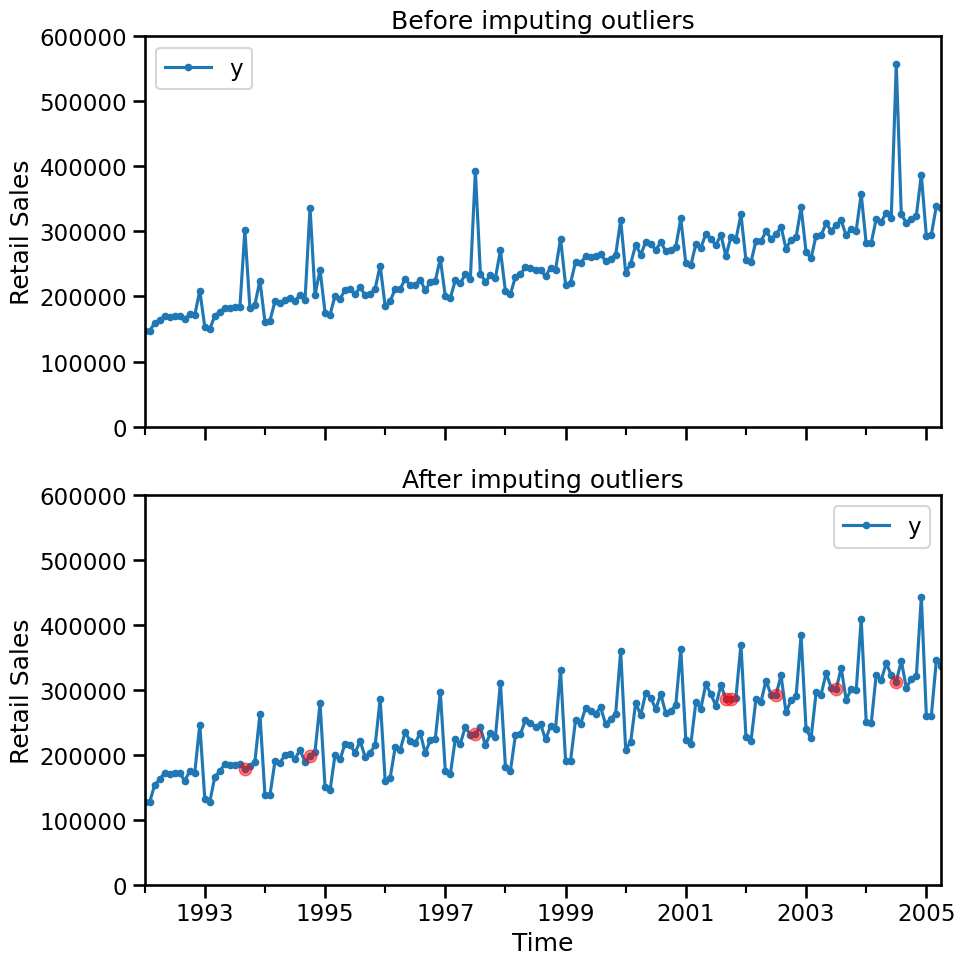

In [9]:
# Set outliers to NaN
df_.loc[df_["is_outlier"], "y"] = np.NaN

# Apply linear interpolation
df_.interpolate(method="linear", inplace=True)

# Add the seasonality extracted from STL back to deseaoned data
df_["y"] = df_["y"] + res.seasonal

# Plot the data and location of the identified outliers from the rolling median method
fig, ax = plt.subplots(nrows=2, figsize=[10, 10], sharex=True)
df.plot(y="y", marker=".", title="Before imputing outliers", ax=ax[0])
df_.plot(y=["y"], marker=".", title="After imputing outliers", ax=ax[1])
df_[df_["is_outlier"]]["y"].plot(
    marker="o", color="r", ax=ax[1], legend=None, linestyle="", alpha=0.5
)

ax[1].set_ylabel("Retail Sales")
ax[0].set_ylabel("Retail Sales")
ax[1].set_xlabel("Time")
ax[0].set_ylim([0, 600000])
ax[1].set_ylim([0, 600000])
plt.tight_layout()

# Detecting outliers using residual and STL 

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import STL

sns.set_context("talk")

In [20]:
df = pd.read_csv(
    "../Datasets/example_retail_sales_with_outliers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)
df.head()

,y
ds,
1992-01-01,146376.0
1992-02-01,147079.0
1992-03-01,159336.0
1992-04-01,163669.0
1992-05-01,170068.0


Text(0.5, 0, 'Time')

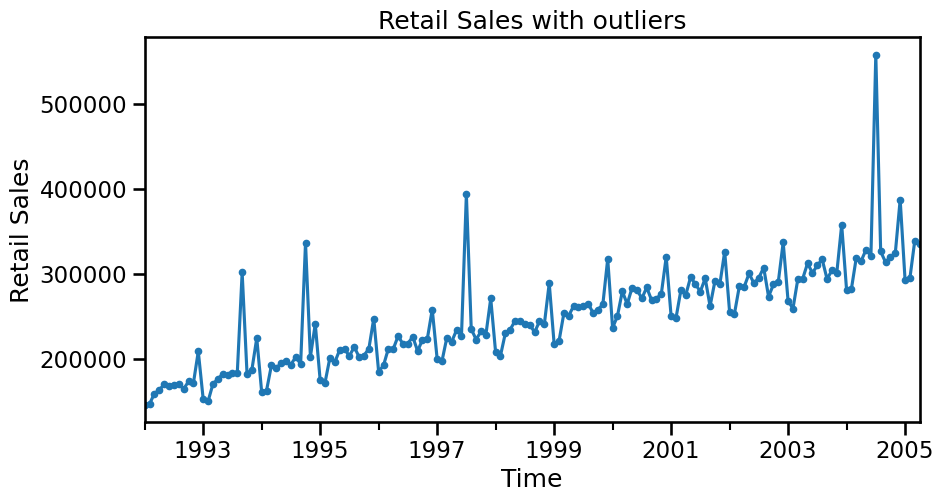

In [18]:
fig, ax = plt.subplots(figsize=[10, 5])
df.plot(y="y", marker=".", figsize=[10, 5], legend=None, ax=ax)
ax.set_title("Retail Sales with outliers")
ax.set_ylabel("Retail Sales")
ax.set_xlabel("Time")

<img src="../images/Screenshot 2024-05-12 131544.jpg">

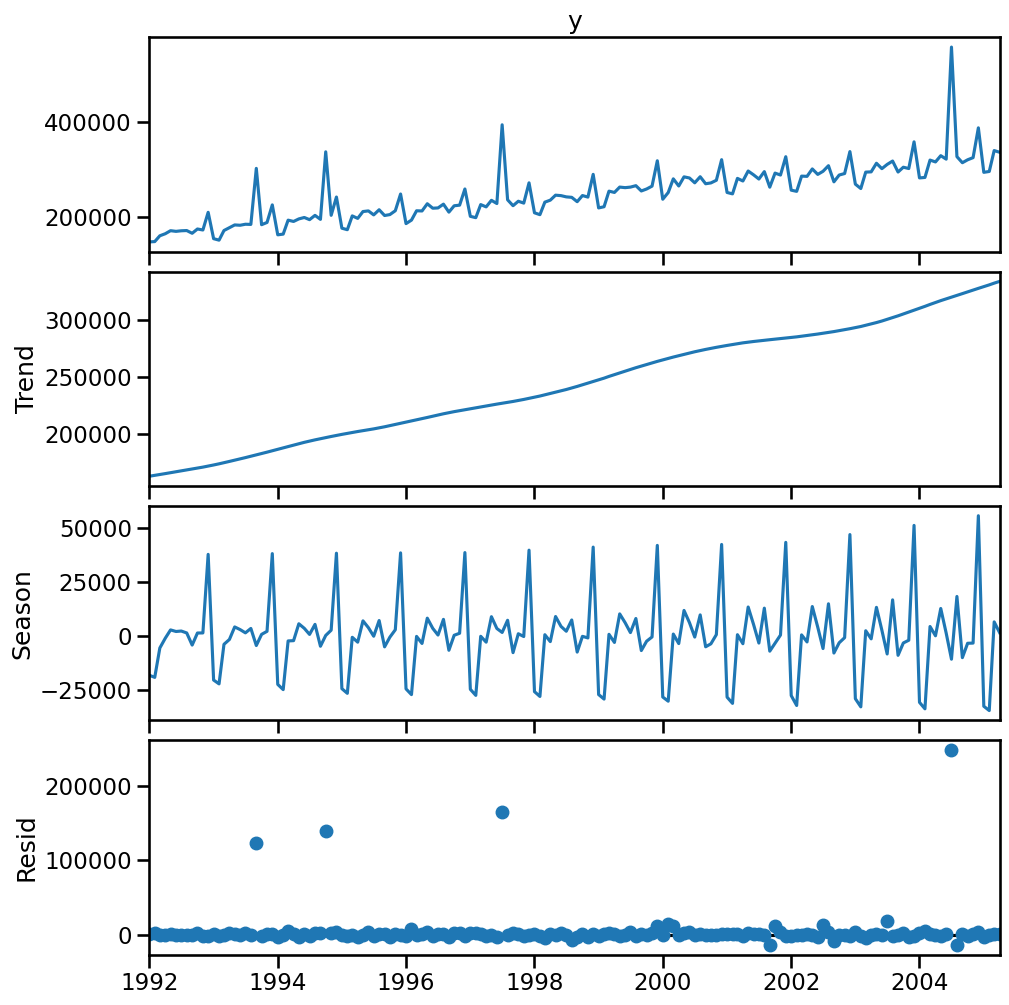

In [21]:
df_ = df.copy()

# Apply STL decomposition
# Setting the robust parameter to true means that a fitting method is used
# that is more robust to outliers.
res = STL(
    df_['y'],
    robust=True,
).fit()


plt.rc("figure", figsize=(10, 10))
plt.rc("font", size=5)
res.plot();

In [22]:
# Compute residuals
df_["residual"] = res.resid

# Compute inter-quartile range
Q1 = df_["residual"].quantile(0.25)
Q3 = df_["residual"].quantile(0.75)
IQR = Q3 - Q1

# Apply 1.5 IQR as a threshold to identify outliers
factor = 1.5
df_["lower"] = Q1 - factor * IQR
df_["upper"] = Q3 + factor * IQR
df_["is_outlier"] = (df_["residual"] < (Q1 - factor * IQR)) | (
    df_["residual"] > (Q3 + factor * IQR)
)

df_.head()

,y,residual,lower,upper,is_outlier
ds,,,,,
1992-01-01,146376.0,984.653087,-5692.104751,5815.647076,False
1992-02-01,147079.0,1922.820053,-5692.104751,5815.647076,False
1992-03-01,159336.0,-233.773804,-5692.104751,5815.647076,False
1992-04-01,163669.0,-1218.191626,-5692.104751,5815.647076,False
1992-05-01,170068.0,548.978491,-5692.104751,5815.647076,False


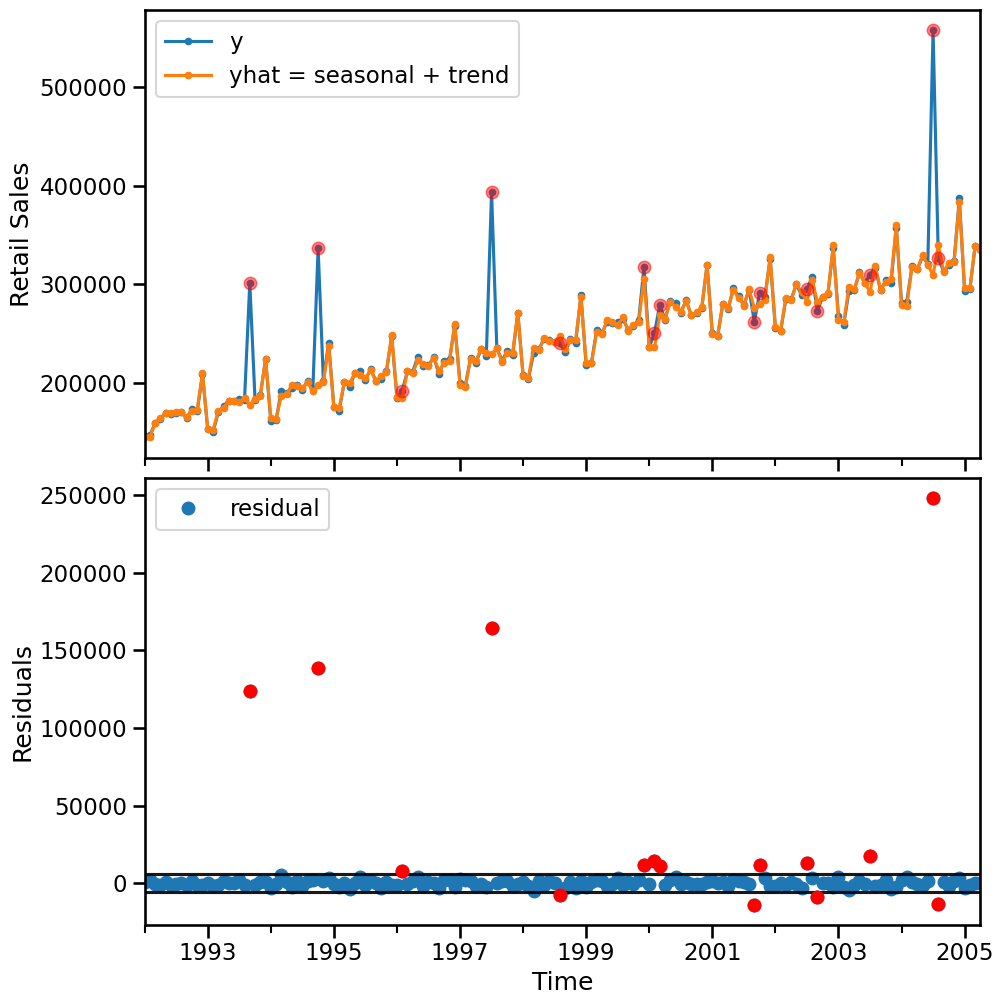

In [23]:
# Plot time series
df_["yhat = seasonal + trend"] = res.seasonal + res.trend

fig, ax = plt.subplots(nrows=2, figsize=[10, 10], sharex=True)
df_.plot(y=["y", "yhat = seasonal + trend"], marker=".", ax=ax[0])
df_["residual"] = df_["residual"]

# Plot residuals
df_.plot(y=["residual"], ax=ax[1], marker="o", linestyle="")
df_.plot(y=["upper", "lower"], ax=ax[1], color="k", legend=None, alpha=0.9)

# If any data points are identified as an outlier, plot them
if df_["is_outlier"].any():
    df_["y"].loc[df_["is_outlier"]].plot(
        marker="o", color="r", ax=ax[0], legend=None, linestyle="", alpha=0.5
    )
    df_["residual"].loc[df_["is_outlier"]].plot(
        marker="o", color="r", ax=ax[1], legend=None, linestyle=""
    )

ax[0].set_ylabel("Retail Sales")
ax[1].set_ylabel("Residuals")

ax[1].set_xlabel("Time")
plt.tight_layout()

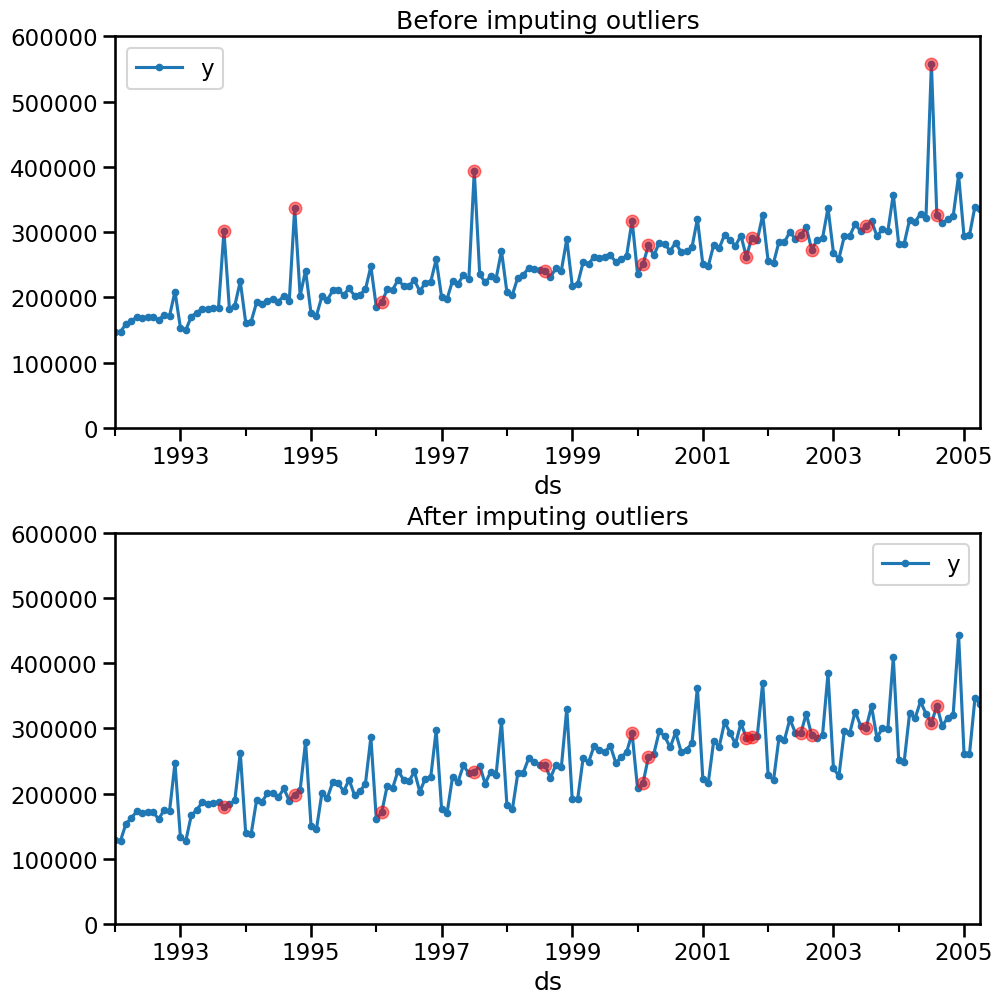

In [24]:
#######  Remove the outliers 
# Once the outliers are identified and a choice is made to remove them they can be imputed using missing value methods or using the values from the estimation methods.As an example we shall use linear interpolation.
# Set outliers to NaN
df_.loc[df_["is_outlier"], "y"] = np.NaN

# Apply linear interpolation
df_.interpolate(method="linear", inplace=True)

# Add the seasonality extracted from STL back to deseasoned data
df_["y"] = df_["y"] + res.seasonal

# Plot the data and location of the identified outliers from the rolling median method
fig, ax = plt.subplots(nrows=2, figsize=[10, 10])
df.plot(y="y", marker=".", title="Before imputing outliers", ax=ax[0])
df[df_["is_outlier"]]["y"].plot(
    marker="o", color="r", ax=ax[0], legend=None, linestyle="", alpha=0.5
)
df_.plot(y=["y"], marker=".", title="After imputing outliers", ax=ax[1])
df_[df_["is_outlier"]]["y"].plot(
    marker="o", color="r", ax=ax[1], legend=None, linestyle="", alpha=0.5
)
ax[0].set_ylim([0, 600000])
ax[1].set_ylim([0, 600000])

plt.tight_layout()

# Modelling outliers with dummy variables 

In [25]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_context("talk")

In [26]:
# Load retail sales dataset with the artificially added outliers
df = pd.read_csv(
    "../Datasets/example_retail_sales_with_outliers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

Text(0.5, 0, 'Time')

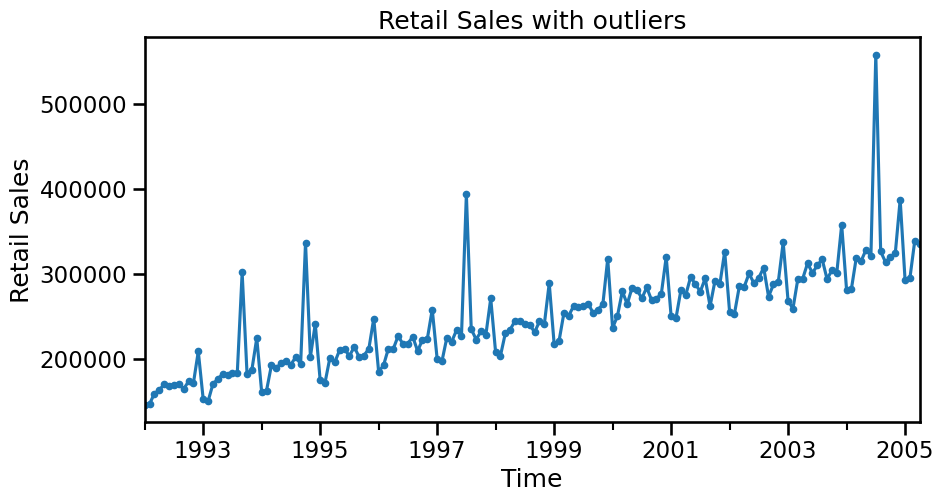

In [27]:
fig, ax = plt.subplots(figsize=[10, 5])
df.plot(y="y", marker=".", figsize=[10, 5], legend=None, ax=ax)
ax.set_title("Retail Sales with outliers")
ax.set_ylabel("Retail Sales")
ax.set_xlabel("Time")


In [28]:
# For this exercise, assume we know the cause of these outliers and therefore we know the dates in the past and future. We're just trying to see the impact of outliers on a model in this notebook.

outlier_dates = [datetime.date(1993, 9, 1),
                 datetime.date(1994, 10, 1),
                 datetime.date(1997, 7, 1),
                 datetime.date(2004, 7, 1)]

### create dummy variables 
df["is_outlier"] = np.where(df.index.isin(outlier_dates), 1, 0)


## Adding a dummy variable allows us to estimate the impact of future outlier or special events. This is useful when we know in advance when such events will occur.